<a href="https://colab.research.google.com/github/braddirt/CSE450Module5/blob/main/starter_signs_v2_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (224, 224)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2)
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


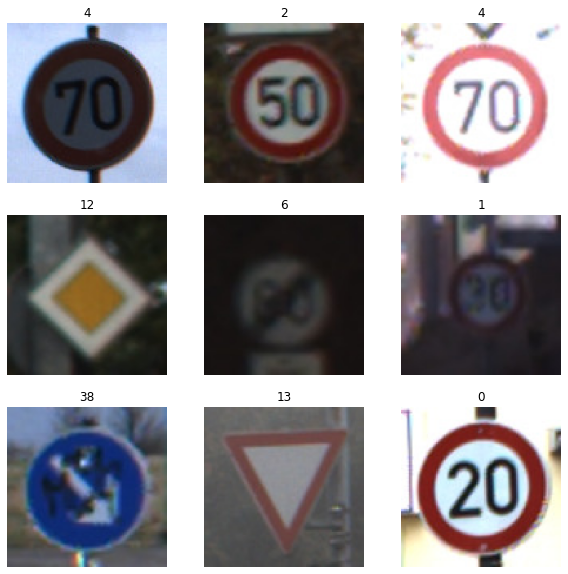

In [4]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]      
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [5]:
# Build a model...
from keras.backend import categorical_crossentropy
from tensorflow.keras.models import Sequential
model = tf.keras.applications.vgg16.VGG16(
                                            pooling='avg',
                                            include_top=False, weights='imagenet',
                                            classes=42,
                                            classifier_activation='softmax')
model.summary()
model.layers[-1]

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [7]:
steps_per_epoch_valid = len(validation_generator)
number_of_epochs = 2
steps_per_epoch_train = len(train_generator)
model.compile(loss="sparse_categorical_crossentropy")
fit_history =model.fit(train_generator, steps_per_epoch=steps_per_epoch_train,
                                 epochs=number_of_epochs,
                                 verbose = 1,
                                 validation_data=validation_generator,
                                 validation_steps=steps_per_epoch_valid)

Epoch 1/2
981/981 [==============================] - 862s 877ms/step - loss: 13.5530 - val_loss: 13.5523
Epoch 2/2
981/981 [==============================] - 859s 876ms/step - loss: 13.5530 - val_loss: 13.5523


## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before. 

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

Found 201 images belonging to 1 classes.


##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset. 

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does. 

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

Found 12630 images belonging to 1 classes.
